<a href="https://colab.research.google.com/github/Shogo-dayo/WebTour/blob/main/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Description

*   user_id - User ID (ユーザID)
*   check-in - Reservation check-in date（チェックイン）
*   checkout - Reservation check-out date（チェックアウト）
*   affiliate_id - An anonymized ID of affiliate channels where the booker came from (e.g. direct, some third party referrals, paid search engine, etc.)　（どこのサイトから飛んできたのか）
*   device_class - desktop/mobile (どのデバイスから)
*   booker_country - Country from which the reservation was made (anonymized) (旅行者の出身国)
*   hotel_country - Country of the hotel (anonymized)　（ホテルのある国）
*   city_id - city_id of the hotel’s city (anonymized)　（ホテルがある市のid）　-> 　これを予測する
*   utrip_id - Unique identification of user’s trip (a group of multi-destinations bookings within the same trip) -> そのユーザの何回目の旅行なのか

予約のチエックアウト日は，その旅行の次の予約のチェックイン数







# Goal

The goal of the challenge is to predict (and recommend) the final city (city_id) of each trip (utrip_id). We will evaluate the quality of the predictions based on the top four recommended cities for each trip by using Precision@4 metric (4 representing the four suggestion slots at Booking.com website). When the true city is one of the top 4 suggestions (regardless of the order), it is considered correct.

上位4つの都市を出力して，その中の実際の旅行先が入っているを正解

In [ ]:
from google import colab
colab.drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib as mpl
mpl.use('Agg')


import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
import pandas as pd
from datetime import timedelta
import sys
import time
import glob
import datetime

from sklearn.cluster import KMeans
import scipy.stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_samples
from sklearn import datasets
%matplotlib inline
import os
from sklearn.preprocessing import LabelBinarizer


from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing

# Data Analytics

In [ ]:
input_path = '/content/drive/My Drive/CompeData/WebTour/booking_train_set.csv'
df = pd.read_csv(input_path)

In [ ]:
df.drop("Unnamed: 0",axis=1,inplace=True)

In [ ]:
df.head(5)

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id
0,1006220,2016-04-09,2016-04-11,31114,desktop,384,Gondal,Gondal,1006220_1
1,1006220,2016-04-11,2016-04-12,39641,desktop,384,Gondal,Gondal,1006220_1
2,1006220,2016-04-12,2016-04-16,20232,desktop,384,Gondal,Glubbdubdrib,1006220_1
3,1006220,2016-04-16,2016-04-17,24144,desktop,384,Gondal,Gondal,1006220_1
4,1010293,2016-07-09,2016-07-10,5325,mobile,359,The Devilfire Empire,Cobra Island,1010293_1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166835 entries, 0 to 1166834
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   user_id         1166835 non-null  int64 
 1   checkin         1166835 non-null  object
 2   checkout        1166835 non-null  object
 3   city_id         1166835 non-null  int64 
 4   device_class    1166835 non-null  object
 5   affiliate_id    1166835 non-null  int64 
 6   booker_country  1166835 non-null  object
 7   hotel_country   1166835 non-null  object
 8   utrip_id        1166835 non-null  object
dtypes: int64(3), object(6)
memory usage: 80.1+ MB


In [ ]:
print('There are {} rows and {} columns in df'.format(df.shape[0], df.shape[1]))

There are 1166835 rows and 9 columns in df


In [ ]:
df.isnull().sum()

user_id           0
checkin           0
checkout          0
city_id           0
device_class      0
affiliate_id      0
booker_country    0
hotel_country     0
utrip_id          0
dtype: int64

## Numeric Data(数値データ)

In [ ]:
# df.hist(bins=50, figsize=(20,15))
# plt.show()

### user_id

#### 各ユーザごとのチェックイン数を把握

In [ ]:
uniq_user_count = df['user_id'].value_counts()
print(uniq_user_count)

2209265    172
870848     137
3635431    123
362194     102
5819402     94
          ... 
4019208      1
255680       1
3164490      1
849117       1
1144248      1
Name: user_id, Length: 200153, dtype: int64


#### 各都市ごとのチェックイン数

In [ ]:
uniq_cityid_count = df['city_id'].value_counts()
uniq_cityid_count

47499    11242
23921    10511
36063     9559
17013     9011
29319     8179
         ...  
42494        1
44543        1
65995        1
23008        1
2049         1
Name: city_id, Length: 39901, dtype: int64

#### affiliate id（Booking.com自体から来たのか，広告などから飛んで予約しに来たのか）ごとのカウント

In [ ]:
uniq_affiliateid_count = df['affiliate_id'].value_counts()
uniq_affiliateid_count

9924     277775
359      171385
384       88137
9452      85476
4541      41504
          ...  
8351          1
8464          1
2202          1
10513         1
2047          1
Name: affiliate_id, Length: 3254, dtype: int64

## object Data

In [ ]:
df["checkin"] = pd.to_datetime(df["checkin"])
df["checkout"] = pd.to_datetime(df["checkout"])

In [ ]:
df["stay"] = df["checkout"] - df["checkin"]

In [ ]:
df.head(30)

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,stay
0,1006220,2016-04-09,2016-04-11,31114,desktop,384,Gondal,Gondal,1006220_1,2 days
1,1006220,2016-04-11,2016-04-12,39641,desktop,384,Gondal,Gondal,1006220_1,1 days
2,1006220,2016-04-12,2016-04-16,20232,desktop,384,Gondal,Glubbdubdrib,1006220_1,4 days
3,1006220,2016-04-16,2016-04-17,24144,desktop,384,Gondal,Gondal,1006220_1,1 days
4,1010293,2016-07-09,2016-07-10,5325,mobile,359,The Devilfire Empire,Cobra Island,1010293_1,1 days
5,1010293,2016-07-10,2016-07-11,55,mobile,359,The Devilfire Empire,Cobra Island,1010293_1,1 days
6,1010293,2016-07-12,2016-07-13,23921,mobile,359,The Devilfire Empire,Cobra Island,1010293_1,1 days
7,1010293,2016-07-13,2016-07-15,65322,desktop,9924,The Devilfire Empire,Cobra Island,1010293_1,2 days
8,1010293,2016-07-15,2016-07-16,23921,desktop,9924,The Devilfire Empire,Cobra Island,1010293_1,1 days
9,1010293,2016-07-16,2016-07-17,20545,desktop,10573,The Devilfire Empire,Cobra Island,1010293_1,1 days


In [ ]:
df[df["user_id"] == 1024544]

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,stay
18,1024544,2016-08-02,2016-08-03,50957,tablet,3631,The Devilfire Empire,Borginia,1024544_2,1 days
19,1024544,2016-08-03,2016-08-05,60222,desktop,9924,The Devilfire Empire,Borginia,1024544_2,2 days
20,1024544,2016-08-05,2016-08-06,23612,tablet,3631,The Devilfire Empire,Borginia,1024544_2,1 days
21,1024544,2016-08-06,2016-08-09,17013,desktop,9924,The Devilfire Empire,Borginia,1024544_2,3 days
22,1024544,2016-08-09,2016-08-10,46794,tablet,3631,The Devilfire Empire,Lilliput,1024544_2,1 days


## Godal -> India
## The Devilfire Empire -> ?????
## Elbonia -> western European country
## Tcherkistan -> East European country
## Bartovia -> a European Country in the Simpsons

In [ ]:
df["booker_country"].value_counts()

Gondal                  536036
The Devilfire Empire    286244
Elbonia                 235344
Tcherkistan              80573
Bartovia                 28638
Name: booker_country, dtype: int64

In [ ]:
for index, group in df.groupby("hotel_country"):
  # 平均ホテル滞在数は
  print(index, group["stay"].mean())

Absurdistan 1 days 20:25:56.756756756
Aldorria 2 days 19:07:46.503667481
Aldovia 2 days 03:41:14.773027081
Almaigne 2 days 13:42:51.428571428
Altis and Stratis, Republic of 1 days 15:02:58.512396694
Alvonia 1 days 21:55:37.885385821
Angrezi Raj 2 days 00:00:00
Aslerfan 1 days 17:33:40.159803319
Atlantis 1 days 22:00:28.698710433
Axphain 2 days 01:09:23.710435600
Babar's Kingdom 3 days 12:00:00
Bacteria 2 days 06:13:34.190687361
Bahari 3 days 00:00:00
Bahavia 1 days 19:57:43.229308005
Baltish 1 days 19:06:29.808917197
Bandaria 1 days 14:13:05.334555453
Bangalla 1 days 16:36:55.384615384
Bartovia 1 days 15:16:05.437482225
Basran 2 days 04:21:49.090909090
Bialya 2 days 11:01:37.297297297
Bolumbia 2 days 00:17:37.419683834
Borginia 1 days 17:59:15.028600232
Borostyria 2 days 09:47:55.739644970
Bozatta 1 days 15:11:13.819552205
Braganza, Dominion of 1 days 10:59:02.857142857
Brobdingnag 1 days 07:23:04.615384615
Bruzundanga 1 days 23:12:47.213114754
Buenaventura 3 days 00:00:00
Bultan 1 day

## 違うホテルへの遷移確率算出

In [ ]:
# 違うホテルへの遷移確率は
list_transition_rate = []
for index, group in df.groupby("user_id"):
  uniq_hotel_country = group["hotel_country"].unique().tolist()
  list_transition_rate.append([index,uniq_hotel_country])

In [ ]:
visitHotel_df = pd.DataFrame(list_transition_rate,columns=["user_id", "visitHotel"])

In [ ]:
visitHotel_df

,user_id,visitHotel
0,29,[Elbonia]
1,81,"[Elbonia, Leutonia]"
2,136,"[Osterlich, Sylvania, Slaka]"
3,149,[Kangan]
4,156,"[Leutonia, Kazahrus, Urkesh]"
...,...,...
200148,6257979,"[Cobra Island, Santa Prisca]"
200149,6258017,"[Kasnia, Sarkhan]"
200150,6258041,[Glubbdubdrib]
200151,6258065,[Pullamawang]


# categorical変数を numeriacl dataに変更する

In [ ]:
from sklearn import preprocessing
le_device = preprocessing.LabelEncoder()

# Streetの列のユニーク値を抽出
device_uniq = df["device_class"].unique()

# labelEncoder
le_device.fit(device_uniq)
df["device_class"] = le_device.transform(df["device_class"])

In [ ]:
le_booker = preprocessing.LabelEncoder()

# Streetの列のユニーク値を抽出
booker_uniq = df["booker_country"].unique()

# labelEncoder
le_booker.fit(booker_uniq)
df["booker_country"] = le_booker.transform(df["booker_country"])

In [ ]:
le_hotel = preprocessing.LabelEncoder()

# Streetの列のユニーク値を抽出
hotel_uniq = df["hotel_country"].unique()

# labelEncoder
le_hotel.fit(hotel_uniq)
df["hotel_country"] = le_hotel.transform(df["hotel_country"])

In [ ]:
df["hotel_country"].value_counts().plot(kind ="bar")

36     137791
52     117717
60     104979
59      74840
46      53965
        ...  
115         1
120         1
188         1
137         1
27          1
Name: hotel_country, Length: 195, dtype: int64

In [ ]:
df["booker_country"].value_counts().plot(kind ="bar")

2    536036
4    286244
1    235344
3     80573
0     28638
Name: booker_country, dtype: int64

In [ ]:
df

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,stay
0,1006220,2016-04-09,2016-04-11,31114,0,384,2,60,1006220_1,2 days
1,1006220,2016-04-11,2016-04-12,39641,0,384,2,60,1006220_1,1 days
2,1006220,2016-04-12,2016-04-16,20232,0,384,2,59,1006220_1,4 days
3,1006220,2016-04-16,2016-04-17,24144,0,384,2,60,1006220_1,1 days
4,1010293,2016-07-09,2016-07-10,5325,1,359,4,36,1010293_1,1 days
...,...,...,...,...,...,...,...,...,...,...
1166830,999261,2016-09-13,2016-09-15,14197,2,10332,2,52,999261_1,2 days
1166831,999755,2016-12-13,2016-12-16,4476,0,2661,4,60,999755_1,3 days
1166832,999755,2016-12-16,2016-12-17,1034,0,7974,4,60,999755_1,1 days
1166833,999755,2016-12-22,2016-12-25,64876,0,7974,4,52,999755_1,3 days


In [ ]:
df["stay"]

0         2 days
1         1 days
2         4 days
3         1 days
4         1 days
           ...  
1166830   2 days
1166831   3 days
1166832   1 days
1166833   3 days
1166834   3 days
Name: stay, Length: 1166835, dtype: timedelta64[ns]

In [ ]:
df["stay"] = (df["stay"] / np.timedelta64(1, 'D')).astype(int)

In [ ]:
df.head(5)

,user_id,checkin,checkout,city_id,device_class,affiliate_id,booker_country,hotel_country,utrip_id,stay
0,1006220,2016-04-09,2016-04-11,31114,0,384,2,60,1006220_1,2
1,1006220,2016-04-11,2016-04-12,39641,0,384,2,60,1006220_1,1
2,1006220,2016-04-12,2016-04-16,20232,0,384,2,59,1006220_1,4
3,1006220,2016-04-16,2016-04-17,24144,0,384,2,60,1006220_1,1
4,1010293,2016-07-09,2016-07-10,5325,1,359,4,36,1010293_1,1


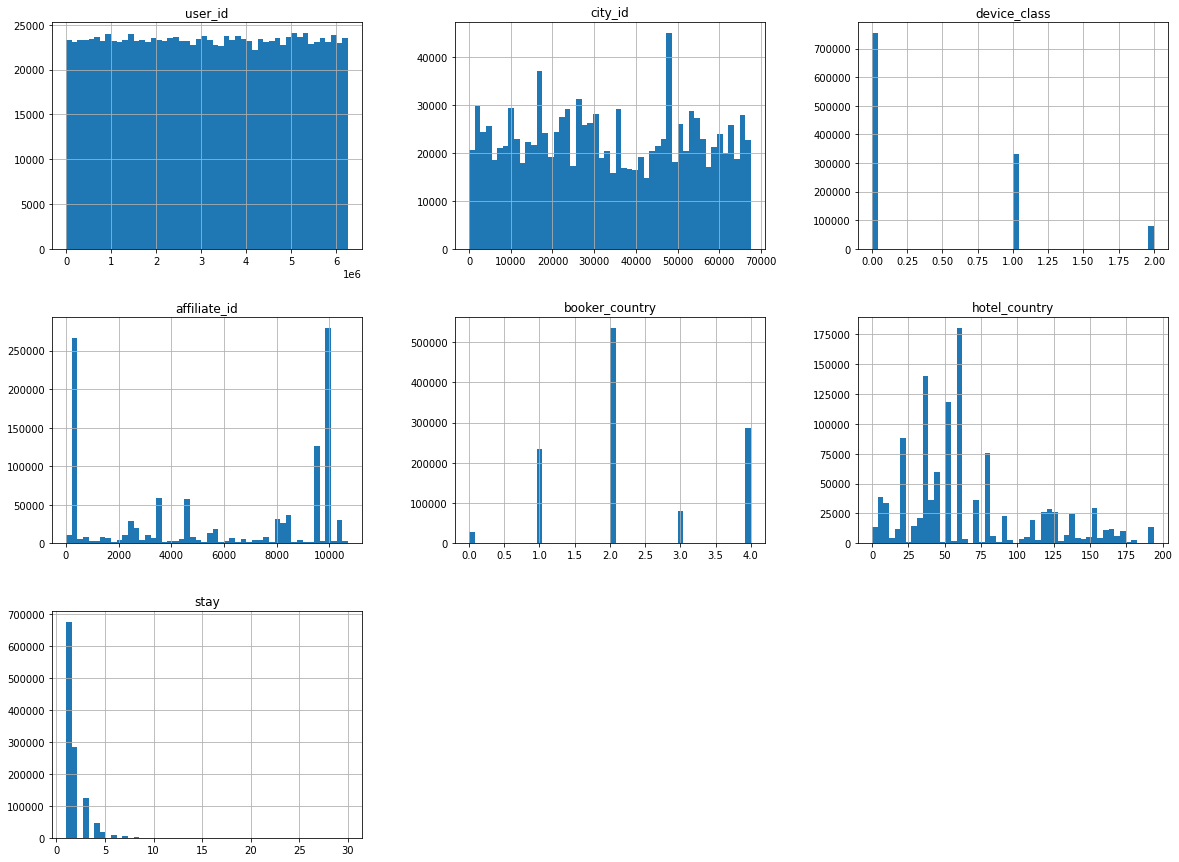

In [ ]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
obj_columns = df.select_dtypes(include=['object']).columns
numb_columns = df.select_dtypes(include=['number']).columns

In [ ]:
for col in numb_columns:
    print('{:15}'.format(col), 
          'Mean: {:05.2f}'.format(df[col].mean()) , 
          '   ' ,
          'Std: {:05.2f}'.format(df[col].std()) , 
          '   ' ,
          'Skewness: {:05.2f}'.format(df[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(df[col].kurt())  
         )

user_id         Mean: 3129534.65     Std: 1808044.51     Skewness: 00.00     Kurtosis: -01.20
city_id         Mean: 33470.59     Std: 19582.55     Skewness: 00.03     Kurtosis: -01.22
device_class    Mean: 00.42     Std: 00.62     Skewness: 01.17     Kurtosis: 000.28
affiliate_id    Mean: 5719.50     Std: 3964.43     Skewness: -0.22     Kurtosis: -01.64
booker_country  Mean: 02.31     Std: 01.12     Skewness: 00.31     Kurtosis: -00.89
hotel_country   Mean: 66.23     Std: 44.45     Skewness: 00.95     Kurtosis: 000.12
stay            Mean: 01.74     Std: 01.20     Skewness: 03.35     Kurtosis: 027.57


### 相関行列のヒートマップ（targetはcity_id）

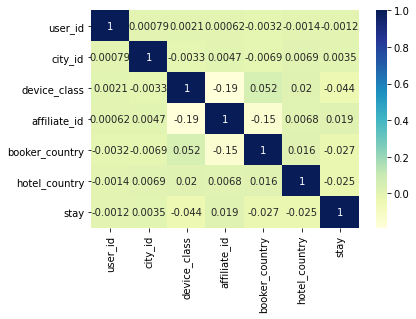

In [ ]:
corr = df.corr()
# corr[np.abs(corr) < 0.1] = 0  ## corr<0.1  =>  corr=0 
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.show()

### 外れ値確認用(city_idに対しての各説明変数のプロット)

KeyboardInterrupt: ignored

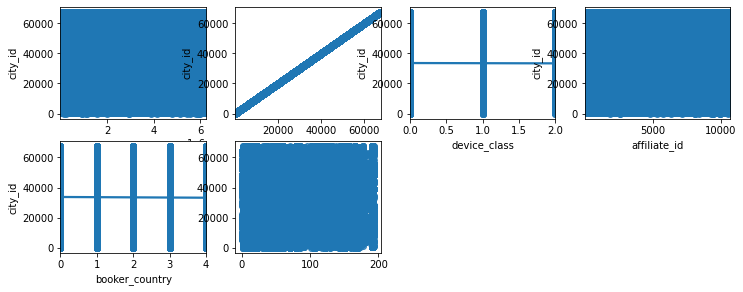

In [ ]:
## plotに時間かかるので注意
# numb_df = df[numb_columns]
# y_train = df["city_id"]

# fig = plt.figure(figsize=(12,7))
# for i in np.arange(10):
#     ax = fig.add_subplot(3,4,i+1)
#     sns.regplot(x=numb_df.iloc[:,i], y=y_train)

# plt.tight_layout()
# plt.show()